# HDF5

The Hierarchical Data Format v.5 (HDF5) is a format for large data storage which, as the name implies, allows for hierarchical field of data. HDF5 offers us an "easy" way to save and access experimental data in a portable way, as HDF5 is an open standard and has been implemented in Java, Matlab, Mathematica, Python, R, and of course for our purposes, Julia. This is in contrast to, for example, the Matlab-specific `.mat` file format. While other open approaches, such as pickling (Python), XML, or even raw CSV dumps, can be used, these methods don't scale well to the storage of large sets of diverse data. 

For full documentation, see the package website
[HDF5.jl](https://github.com/JuliaIO/HDF5.jl).


In [1]:
# Grab the HDF5 package if you don't have it already.
Pkg.add("HDF5")
Pkg.build("HDF5")

INFO: No packages to install, update or remove
INFO: Package database updated
INFO: Building Homebrew


HEAD is now at 21ca138 Resource.unpack: install invisible files and dirs
Updating tap homebrew-core
HEAD is now at 252a520 doctl: audit fix and empty resources array fix
Updating tap homebrew-juliadeps
HEAD is now at c377b50 Merge pull request #92 from staticfloat/staging


INFO: Building Blosc
INFO: Building HDF5


In [2]:
# Use this package
using HDF5

Using HDF5, we can do some rather simple writing/reading from HDF5 files.

In [8]:
# Create some random data
a = rand([1,2,3,4],5,5)
println("Wrote Data:")
println(a)   # Show the value

# Avoid HDF5 errors being thrown about overwriting
if isfile("tmp.h5")
    rm("tmp.h5")
end

# Write to file
h5write("tmp.h5","a",a)

# Read back from file
b = h5read("tmp.h5","a")
println("Read Data:")
println(b)   # Show the value

# Read back just a slice of data
b = h5read("tmp.h5","a",(1:2,1:2))
println("Read Data:")
println(b)   # Show the value

Wrote Data:
[2 4 2 4 2
 4 1 1 2 4
 2 1 4 3 3
 4 2 3 2 4
 3 1 1 4 3]
Read Data:
[2 4 2 4 2
 4 1 1 2 4
 2 1 4 3 3
 4 2 3 2 4
 3 1 1 4 3]
Read Data:
[2 4
 4 1]


Now lets take a look at the "hierarchical" aspect of HDF5. Specifically, we can save data in a path-like structure, much like a file-system, within an HDF5 file. We'll write in a structure like

```text
    top
       /params
              /a
              /b
              /c
    bot
       /params
              /a
              /b
              /c
```

In [12]:
# Just some random data...
aValues = rand(collect(1:5),5)
bValues = rand(collect(1:5),5)
cValues = rand(collect(1:5),5)

# Clear out vestigal file.
if isfile("tmp.h5")
    rm("tmp.h5")
end

# Write to an HDF5 file in arbitrary locations
h5write("tmp.h5","top/params/a",aValues)
h5write("tmp.h5","top/params/b",bValues)
h5write("tmp.h5","top/params/c",cValues)
h5write("tmp.h5","bot/params/a",aValues)
h5write("tmp.h5","bot/params/b",bValues)
h5write("tmp.h5","bot/params/c",cValues)

# Read in data
D = h5read("tmp.h5","/")

Dict{ByteString,Any} with 2 entries:
  "top" => Dict{ByteString,Any}("params"=>Dict{ByteString,Any}("c"=>[5,5,2,4,5]…
  "bot" => Dict{ByteString,Any}("params"=>Dict{ByteString,Any}("c"=>[5,5,2,4,5]…

We see that the returned value, in this case, is not an array, but rather a **dictionary** of values representing the structure of the HDF5 file.

In [13]:
D["top"]["params"]

Dict{ByteString,Any} with 3 entries:
  "c" => [5,5,2,4,5]
  "b" => [3,2,3,1,1]
  "a" => [4,4,3,3,4]

In [14]:
D["bot"]["params"]

Dict{ByteString,Any} with 3 entries:
  "c" => [5,5,2,4,5]
  "b" => [3,2,3,1,1]
  "a" => [4,4,3,3,4]

In [15]:
D["bot"]["params"]["a"][1]

4

----
## "Practical" Expample -- Experimental Data

Lets say that we have a stochastic experiment, and we need to run this experiment and store the results for further analysis. 

In [5]:
"""
run_experiment_foo(;freq = 1.0, sigma = 0.2, N = 1000)

# Description
Run our fake experiment.
"""
function run_experiment_foo(;freq = 1.0, sigma = 0.2, N = 1000)
    if N > 2000
        error("Whoa! We encountered an arbitrary bug in our experiment!")
    end
    y = [sin(freq*i) for i in linspace(0,2*pi,N)]
    z = y + sigma*randn(size(y))
    timeStamp = now()
    return y, z, timeStamp
end

run_experiment_foo (generic function with 1 method)

In [6]:
# Set some parameters on your experiment
numTrials = 5

# We will run four different experiments with four different settings
freqs  = [0.2, 0.5,1.0,2.0]
sigmas = [0.01,0.5,0.2,1.0]

# Some names for our different experiments
expNames = ["experimentA","experimentB", "experimentC", "experimentD"]

# Construct a set of parameters for our experiments
params = Dict()
params[expNames[1]] = Dict("freq" => 0.2, "sigma" => 0.01, "N" => 50)
params[expNames[2]] = Dict("freq" => 0.5, "sigma" => 0.50, "N" => 100)
params[expNames[3]] = Dict("freq" => 1.0, "sigma" => 0.20, "N" => 1000)
params[expNames[4]] = Dict("freq" => 2.0, "sigma" => 1.00, "N" => 5000)

# Run the different experiments
for exp in expNames
    for trial in 1:numTrials
        groundTruth, noisy, timeStamp = run_experiment_foo(freq  = params[exp]["freq"],
                                                           sigma = params[exp]["sigma"], 
                                                           N = params[exp]["N"])
    end    
end

LoadError: LoadError: Whoa! We encountered an arbitrary bug in our experiment!
while loading In[6], in expression starting on line 19

So, now we have our experimental framework, but where is our result data? We could store it in an array at each loop, but then what happens if our execution terminates, or we encounter a bug like the one we see above? We could potentially lose all of our data if, for example, our Julia session crashes, the computer is turned off, water starts coming from the ENS ceiling, etc. So a better pipeline would be to save our data as we go. Lets use HDF5 to accomplish that.

In [7]:
# Some arbitrary file
h5FileName = "testExperiment.h5"

# Run the different experiments
for exp in expNames
    h5write(h5FileName, string(exp,"/params/freq"), [params[exp]["freq"]])
    h5write(h5FileName, string(exp,"/params/sigma"), [params[exp]["sigma"]])
        h5write(h5FileName, string(exp,"/params/N"), [params[exp]["N"]])
    for trial in 1:numTrials
        trueData, noisyData, timeStamp = run_experiment_foo(freq  = params[exp]["freq"],
                                                           sigma = params[exp]["sigma"], 
                                                           N = params[exp]["N"])
        # For clarity, construct the prefix
        h5TrialDataPath = string(exp,"/trial",trial,"/")
        println("Writing to group [$h5TrialDataPath]")
        
        # Write data to HDF5
        h5write(h5FileName, string(h5TrialDataPath,"trueData"), trueData)
        h5write(h5FileName, string(h5TrialDataPath,"noisyData"), noisyData)
        h5write(h5FileName, string(h5TrialDataPath,"timeStamp"), string(timeStamp))
    end    
end

HDF5-DIAG: Error detected in HDF5 (1.8.15-patch1) thread 0:
  #000: H5D.c line 194 in H5Dcreate2(): unable to create dataset
    major: Dataset
    minor: Unable to initialize object
  #001: H5Dint.c line 453 in H5D__create_named(): unable to create and link to dataset
    major: Dataset
    minor: Unable to initialize object
  #002: H5L.c line 1638 in H5L_link_object(): unable to create new link to object
    major: Links
    minor: Unable to initialize object
  #003: H5L.c line 1882 in H5L_create_real(): can't insert link
    major: Symbol table
    minor: Unable to insert object
  #004: H5Gtraverse.c line 861 in H5G_traverse(): internal path traversal failed
    major: Symbol table
    minor: Object not found
  #005: H5Gtraverse.c line 641 in H5G_traverse_real(): traversal operator failed
    major: Symbol table
    minor: Callback failed
  #006: H5L.c line 1674 in H5L_link_cb(): name already exists
    major: Symbol table
    minor: Object already exists


LoadError: LoadError: Error creating dataset //experimentA/params/freq
while loading In[7], in expression starting on line 5

And there we go! We now have all of our experimental data stored in an HDF5 file for later perusal. For example, lets say that we wanted to take a look at the results of the first experiment.

In [8]:
expA = h5read(h5FileName,expNames[1])

Dict{ByteString,Any} with 6 entries:
  "trial3" => Dict{ByteString,Any}("trueData"=>[0.0,0.0256428,0.0512688,0.07686…
  "trial2" => Dict{ByteString,Any}("trueData"=>[0.0,0.0256428,0.0512688,0.07686…
  "trial4" => Dict{ByteString,Any}("trueData"=>[0.0,0.0256428,0.0512688,0.07686…
  "trial1" => Dict{ByteString,Any}("trueData"=>[0.0,0.0256428,0.0512688,0.07686…
  "params" => Dict{ByteString,Any}("sigma"=>[0.01],"N"=>[50],"freq"=>[0.2])
  "trial5" => Dict{ByteString,Any}("trueData"=>[0.0,0.0256428,0.0512688,0.07686…

In [9]:
# What conditions did we run this experiment under?
expA["params"]

Dict{ByteString,Any} with 3 entries:
  "sigma" => [0.01]
  "N"     => [50]
  "freq"  => [0.2]

Lets say we want to do a visualization of our dataset...

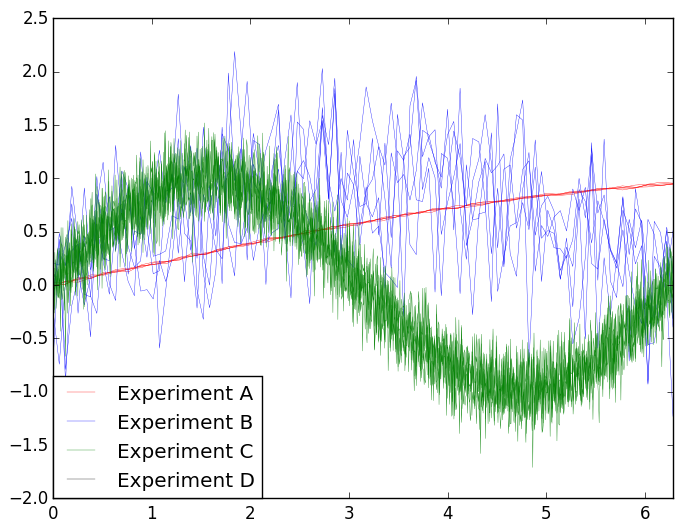

PyObject <matplotlib.legend.Legend object at 0x31fb791d0>

In [10]:
using PyPlot
res = h5read(h5FileName,"/")
colors = Dict("experimentA" => "r", "experimentB" => "b", "experimentC" => "g", "experimentD" => "k")
hold("on")

for exp in keys(res)
    N = res[exp]["params"]["N"][1]
    xDom = linspace(0,2*pi,N)
    for trial in keys(res[exp])
        if trial!="params"
            plot(xDom,res[exp][trial]["noisyData"],color = colors[exp],lw=0.25)
        end
    end
end
hold("off")
xlim(0,2*pi)

# Make some dummy file handles for the legend
lsA = plot([],[],color = colors["experimentA"],lw = 0.25, label = "Experiment A")
lsB = plot([],[],color = colors["experimentB"],lw = 0.25, label = "Experiment B")
lsC = plot([],[],color = colors["experimentC"],lw = 0.25, label = "Experiment C")
lsD = plot([],[],color = colors["experimentD"],lw = 0.25, label = "Experiment D")

legend(handles = [lsA;lsB;lsC;lsD], loc = 3, borderaxespad = 0.0)